In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import warnings

import numpy as np
import xarray as xr
from xgcm import Grid

import matplotlib.pyplot as plt

In [16]:
import xbudget
import regionate
import xwmb

### Load grids and data

In [126]:
gridname = 'rho2' #   choose from ['natv', 'rho2', 'zstr']
dt = 'daily' #       choose from ['monthly', 'daily', 'hourly']

In [127]:
# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_' 
time = "190*"
#time = "1900_02_01"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
# Load snapshot data (for mass tendency term)
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
snap = xr.open_mfdataset(rootdir+filename)

# Align N+1 snapshots so they bound N averages, and select year-long subset
ds = ds.sel(time=slice(snap.time[0], snap.time[-1]))
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))
snap = snap.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming to match hdrake conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao', "salt":'so'})
snap = snap.rename({'temp':'thetao', "salt":'so'})

# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds, snap])

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    'xq': xr.DataArray(ocean_grid['xq'].values, dims=('xq',)),
    'yq': xr.DataArray(ocean_grid['yq'].values, dims=('yq',)),
    'geolon': xr.DataArray(ocean_grid['geolon'].values, dims=('yh','xh')),
    'geolat': xr.DataArray(ocean_grid['geolat'].values, dims=('yh','xh')),
    'geolon_u': xr.DataArray(ocean_grid['geolon_u'].values, dims=('yh','xq')),
    'geolat_u': xr.DataArray(ocean_grid['geolat_u'].values, dims=('yh','xq')),
    'geolon_v': xr.DataArray(ocean_grid['geolon_v'].values, dims=('yq','xh')),
    'geolat_v': xr.DataArray(ocean_grid['geolat_v'].values, dims=('yq','xh')),
    'geolon_c': xr.DataArray(ocean_grid['geolon_c'].values, dims=('yq','xq')),
    'geolat_c': xr.DataArray(ocean_grid['geolat_c'].values, dims=('yq','xq')),
    'dxt': xr.DataArray(ocean_grid['dxt'].values, dims=('yh', 'xh',)),
    'dyt': xr.DataArray(ocean_grid['dyt'].values, dims=('yh', 'xh',)),
    'dxCv': xr.DataArray(ocean_grid['dxCv'].values, dims=('yq', 'xh',)),
    'dyCu': xr.DataArray(ocean_grid['dyCu'].values, dims=('yh', 'xq',)),
    'dxCu': xr.DataArray(ocean_grid['dxCu'].values, dims=('yh', 'xq',)),
    'dyCv': xr.DataArray(ocean_grid['dyCv'].values, dims=('yq', 'xh',)),
    'deptho': xr.DataArray(ocean_grid['deptho'].values, dims=('yh', 'xh',)),
})
ds['lon'] = ds.geolon
ds['lat'] = ds.geolat

ds['sigma2_bounds'] = ds['rhopot2_bounds'] - 1000.
ds['sigma2'] = ds['rhopot2'] - 1000.

# z-coordinate dataset containing basic state variables
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'},
}
metrics = {
    ('X','Y'): "areacello",
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=None)

# Part 1. Water mass budgets within a fixed sub-region

### Collecting high-level budget terms

In [128]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6")
xbudget.collect_budgets(ds, budgets_dict)

KeyError: 'rsdoabsorb'

### Specifying the horizontal boundaries of our water mass

In [ ]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([15.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

### Instantiating the core `WaterMassBudget` class

In [ ]:
wmb = xwmb.WaterMassBudget(
    grid,
    budgets_dict,
    region
)

### Computing water mass budgets

In [35]:
import warnings
import os

def fpath(lam):
    return f"/work/hfd/codedev/xwmb/data/budget_{name}_{lam}_{dt}_{gridname}_updated.nc"

wmts = {}
for lam in ["heat", "salt", "sigma2"]:
    if os.path.isfile(fpath(lam)):
        print("Loading pre-computed WMT.")
        wmts[lam] = xr.open_dataset(fpath(lam))

    else:
        print("Computing WMT...")
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            wmb.mass_budget(lam)
            wmb.wmt.load()
            wmb.wmt.to_netcdf(fpath(lam), mode="w")
            wmts[lam] = wmb.wmt

Computing WMT...
Computing WMT...
Process 'bottom_flux' for component salt is unavailable.
Process 'frazil_ice' for component salt is unavailable.
Computing WMT...


In [ ]:
wmts['heat']['advection'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(Adv)}$")
wmts['heat']['spurious_numerical_mixing'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(Num)}$")
wmts['heat']['diabatic_advection'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(Dia)}$")

In [64]:
wmt = wmts['heat']

boundary_fluxes = [
    'surface_exchange_flux',
    'surface_ocean_flux_advective_negative_lhs',
    'bottom_flux',
    'frazil_ice'
]

wmt['boundary_fluxes'] = sum([wmt[term] for term in boundary_fluxes if term in wmt])

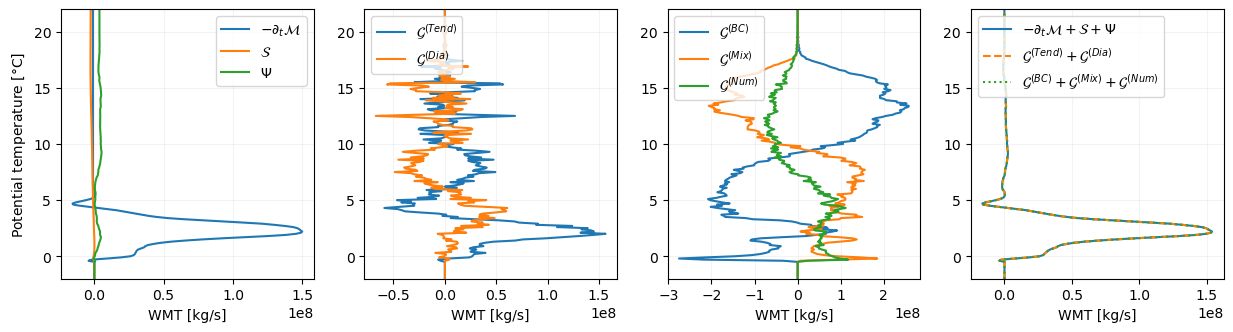

In [90]:
plt.figure(figsize=(15,3.5))

plt.subplot(1,4,1)
(-wmt['mass_tendency']).mean('time').plot(y="thetao_l", label=r"$-\partial_{t} \mathcal{M}$", color="C0")
wmt['mass_source'].mean('time').plot(y="thetao_l", label=r"$\mathcal{S}$", color="C1")
wmt['overturning'].mean('time').plot(y="thetao_l", label=r"$\Psi$", color="C2")
plt.legend()
plt.grid(True, alpha=0.15)
plt.ylim(-2, 22)
plt.xlabel("WMT [kg/s]")
plt.ylabel(r"Potential temperature [$\degree$C]")

plt.subplot(1,4,2)
wmt['Eulerian_tendency'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(Tend)}$", color="C0")
wmt['diabatic_advection'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(Dia)}$", color="C1")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.15)
plt.ylim(-2, 22)
plt.ylabel("")
plt.xlabel("WMT [kg/s]")

plt.subplot(1,4,3)
wmt['boundary_fluxes'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(BC)}$", color="C0")
wmt['diffusion'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(Mix)}$", color="C1")
wmt['spurious_numerical_mixing'].mean('time').plot(y="thetao_l", label=r"$\mathcal{G}^{(Num)}$", color="C2")
plt.legend()
plt.grid(True, alpha=0.15)
plt.ylim(-2, 22)
plt.ylabel("")
plt.xlabel("WMT [kg/s]")

plt.subplot(1,4,4)
label = r"$-\partial_{t} \mathcal{M} + \mathcal{S} + \Psi$"
(-wmt['mass_tendency'] + wmt['mass_source'] + wmt['overturning']).mean('time').plot(y="thetao_l", label=label)
label = r"$\mathcal{G}^{(Tend)} + \mathcal{G}^{(Dia)}$"
(wmt['Eulerian_tendency'] + wmt['diabatic_advection']).mean('time').plot(y="thetao_l", label=label, ls="--")
label= r"$\mathcal{G}^{(BC)} + \mathcal{G}^{(Mix)} + \mathcal{G}^{(Num)}$"
(wmt['boundary_fluxes'] + wmt['diffusion'] + wmt['spurious_numerical_mixing']).mean('time').plot(y="thetao_l", label=label, ls=":")
plt.grid(True, alpha=0.15)
plt.legend(loc="upper left")
plt.ylim(-2, 22)
plt.ylabel("")
plt.xlabel("WMT [kg/s]");

plt.savefig("../figures/paper/three_decompositions.png", bbox_inches="tight", dpi=150)

In [129]:
Δhdt = ((
    ds['thkcello_bounds'].sel(time_bounds=ds['time_bounds'][1:]).rename({'time_bounds':'time'}).assign_coords({"time":ds["time"]}) -
    ds['thkcello_bounds'].sel(time_bounds=ds['time_bounds'][:-1]).rename({'time_bounds':'time'}).assign_coords({"time":ds["time"]})
)/86400)

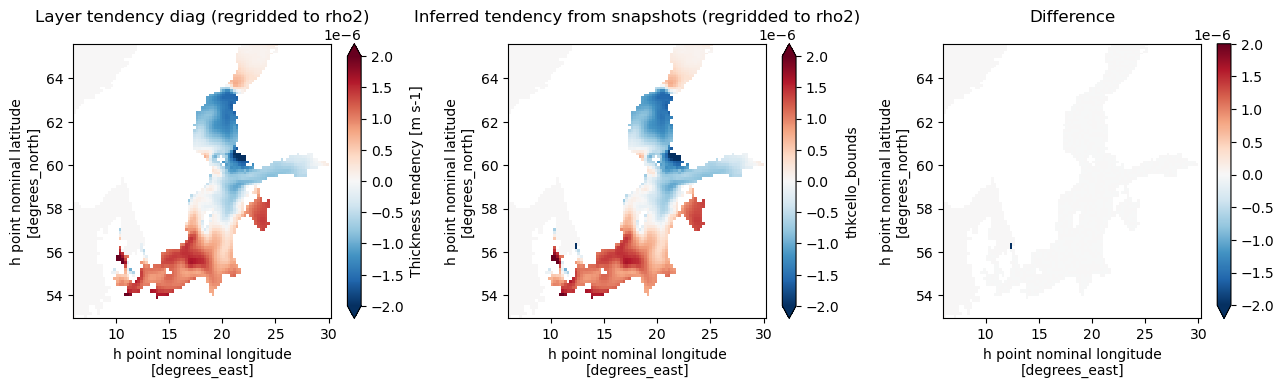

In [153]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
ds['dhdt'].isel(time=0, rho2_l=0).plot(vmin=-2.e-6, vmax=2e-6, cmap="RdBu_r")
plt.title(r"Layer tendency diag (regridded to rho2)", y=1.05)
plt.subplot(1,3,2)
Δhdt.isel(time=0, rho2_l=0).plot(vmin=-2.e-6, vmax=2e-6, cmap="RdBu_r")
plt.title(r"Inferred tendency from snapshots (regridded to rho2)", y=1.05)
plt.subplot(1,3,3)
(Δhdt - ds['dhdt']).isel(time=0, rho2_l=0).plot(vmin=-2.e-6, vmax=2e-6, cmap="RdBu_r")
plt.title("Difference", y=1.05)
plt.tight_layout()

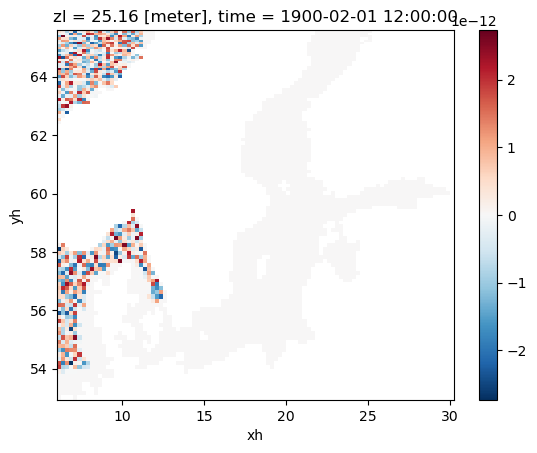

In [114]:
Δhdt

,Array,Chunk
Bytes,2.08 GiB,52.45 MiB
Shape,"(365, 75, 105, 97)","(9, 75, 105, 97)"
Count,88 Graph Layers,73 Chunks
Type,float64,numpy.ndarray


In [109]:
Δhdt

,Array,Chunk
Bytes,2.08 GiB,52.45 MiB
Shape,"(365, 75, 105, 97)","(9, 75, 105, 97)"
Count,88 Graph Layers,73 Chunks
Type,float64,numpy.ndarray
